# Loads the processed h5 file and plots data

debugging: the pump probe signal looks weird after implementing mpi

In [25]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import sys

sys.path.insert(0, '../src/')
from data_analysis import *
from integrators import *
from analysis import *
from pedestals import *
from h5_handling import *

In [42]:
# input parameters
runs = [124,125,126]
run_T_max = 232.8 # K
run_T_min = 231.4 # K

# analysis parameters
#iq_thr = 0.2
iq_thr = 0.6
iq_thr = 1.1

### load and analyse data

In [43]:
def analyse_run(run_num, detector_distance = 0.1249, energy = 9.5, iq_thr = iq_thr, r_min=200, r_max = 400):
    '''
    loads and analyses a single run
    '''
    
    # load data
    run = discover_run_h5(run_num)[3:-3]
    img,Iq,r,nshots,img_hits,thr,nhits,i0,laser_i0,laser_on,event_ID = load_processed_data(run)

    # convert q_scale
    q = q_scale(r,detector_distance=detector_distance,photon_energy=energy*1000)

    # convert intensity to photon/pix
    Iq /=energy
    i0 /=energy

    # normalise to i0
    Iq_norm = np.zeros(Iq.shape)
    i0_avg = np.average(i0)
    norm = i0/i0_avg
    for i in range(int(nshots)):
        Iq_norm[i]=Iq[i]/norm[i]

    # hits
    metric,hits = find_hits(Iq_norm,threshold=iq_thr)
    
    # ice
    filter_length = 1      # 1 = filter off
    ice_thr = 1          # delta photon/pix/i0
    q_min, q_max = 1.0,4.5 # A-1
    ice_metric, ice_hits = find_ice(Iq_norm, q, threshold=ice_thr, 
                                    filter_length=filter_length, q_min=q_min, q_max=q_max)
    hits *= np.logical_not(ice_hits)

    # water hit rate (no ice included)
    hit_rate =len(hits[hits>0])/nshots

    # pump probe
    if hits.sum() > 0:
        hit_avg,miss_avg,diff_signal =  pump_probe_signal(Iq,hits,laser_on)
    else:
        miss_avg = np.average(Iq[np.logical_not(hits) & np.logical_not(ice_hits)], axis=0)
        hit_avg = np.zeros_like(Iq[0])
        diff_signal = np.zeros_like(Iq[0])
    
    return q,hit_avg,miss_avg,diff_signal,hit_rate



In [44]:
n = len(runs)
data = analyse_run(runs[0])
q = data[0]
hit = data[1]
miss = data[2]
diff = data[3]
hr = data[4]

for i in range(1,n):
    data = analyse_run(runs[i])
    hit = np.vstack([hit,data[1]])
    miss = np.vstack([miss,data[2]])
    diff = np.vstack([diff,data[3]])
    hr = np.vstack([hr,data[4]])
    


run0124_droplets_10um_35mm: 18000 shots
run0125_droplets_10um_40mm: 18000 shots
run0126_droplets_10um_40mm: 18000 shots


### plot

<IPython.core.display.Javascript object>


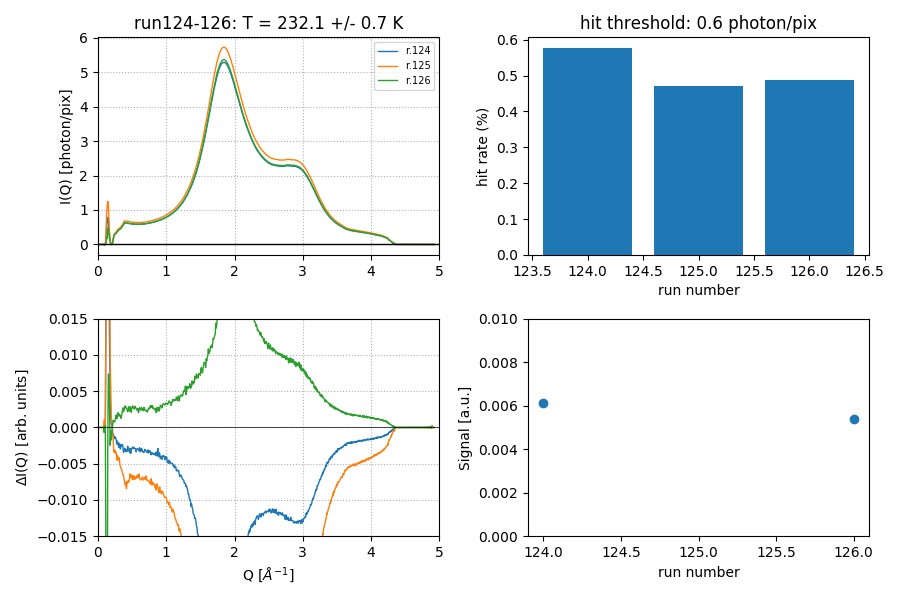

In [41]:
plt.figure(figsize=[9,6])

plt.subplot(2,2,1)
plt.title('run%d-%d: T = %.1f +/- %.1f K' % (np.min(runs), np.max(runs), (run_T_max+run_T_min)/2, (run_T_max-run_T_min)/2))
for i in range(n): 
    plt.plot(q, hit[i] - miss[i], label='r.%d'%(runs[i]),lw=1)
plt.ylabel('I(Q) [photon/pix]')
plt.legend(loc='upper right',fontsize=7)
plt.axhline(0,c='black',lw=1)
plt.xlim(0,5)
plt.grid(linestyle='dotted')

plt.subplot(2,2,3)
for i in range(n): 
    plt.plot(q, diff[i], label=runs[i],lw=1)
plt.ylabel('$\Delta$I(Q) [arb. units]')
plt.ylim([-1.5e-2,1.5e-2])#plt.figure()
plt.xlabel('Q [$\AA^{-1}$]')
#plt.legend(loc='upper right',fontsize=6)
plt.xlim(0,5)
plt.grid(linestyle='dotted')
plt.axhline(0,c='black',lw=0.5)

plt.subplot(2,2,2)
plt.bar(runs,hr*100)
plt.title('hit threshold: %.1f photon/pix' % iq_thr)
plt.xlabel('run number')
plt.ylabel('hit rate (%)')

plt.subplot(2,2,4)
q1,q2 = 10,50
sgnl = np.average(np.abs(diff[:,q1:q2]),axis=1)
plt.plot(runs,sgnl,'o')
plt.ylim([0,1e-2])
plt.ylabel('Signal [a.u.]')
plt.xlabel('run number')

plt.tight_layout()
plt.show()

In [30]:
np.average(np.abs(diff[:,q1:q2]),axis=1)

array([ 0.00054352,  0.00054747,  0.00054754])